# Amazon Sentiment Analysis

# Imports

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

np.random.seed(1)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import torch

### Dataset Location: https://www.kaggle.com/datasets/miriamodeyianypeter/sentiment-analysis-amazon-product-reviews/data

# Functions

In [45]:
from sklearn.metrics import f1_score


def check_class_imbalance(df):
  y = df.values[:,-1]
  counter = Counter(y)
  for k,v in counter.items():
    per = v/len(y) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))

def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores
def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    metric = make_scorer(f1_score)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    param_grid = {
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    metric = make_scorer(f1_score)
    model = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
            
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

In [26]:
PATH = "/Users/maukanmir/Downloads/amazon.csv"

In [27]:
eda_df = pd.read_csv(PATH, nrows=2500)
eda_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,US,11238754,R2JUZ6UMBW405Y,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3,3,N,N,Amazing functionality for the price,"The HD7 does everything well for the price, an...",2015-07-23,1
2496,US,50177203,R13NL9PW2Q310C,B00LCI2I7C,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,Y,hopefully it won't just stop working like the ...,Works well so far....hopefully it won't just s...,2015-07-23,1
2497,US,36499457,R2R3IBDBDY1F2B,B00LCHWEPE,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,N,Five Stars,I am more than pleased with my tablet.,2015-07-23,1
2498,US,50639788,RZNA9A888H5T2,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,1,1,1,N,N,Prime days HD Fire 7 not working,I ordered the Fire HD 7 during the Prime Days ...,2015-07-23,0


# Check for Nulls and Dupes

In [28]:
print(f"Number of Null values: {eda_df.isna().sum()}")
print(f"Number of Dupe values: {eda_df.duplicated().sum()}")

Number of Null values: marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64
Number of Dupe values: 0


In [29]:
eda_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,US,11238754,R2JUZ6UMBW405Y,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3,3,N,N,Amazing functionality for the price,"The HD7 does everything well for the price, an...",2015-07-23,1
2496,US,50177203,R13NL9PW2Q310C,B00LCI2I7C,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,Y,hopefully it won't just stop working like the ...,Works well so far....hopefully it won't just s...,2015-07-23,1
2497,US,36499457,R2R3IBDBDY1F2B,B00LCHWEPE,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,N,Five Stars,I am more than pleased with my tablet.,2015-07-23,1
2498,US,50639788,RZNA9A888H5T2,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,1,1,1,N,N,Prime days HD Fire 7 not working,I ordered the Fire HD 7 during the Prime Days ...,2015-07-23,0


# Drop redundant columns

In [31]:
eda_df.drop(["marketplace", "product_title", "product_category", "vine", "customer_id", "review_id", "product_parent", "product_id", "review_date", "review_headline"], axis=1, inplace=True)

# Separate into another df

In [32]:
df = eda_df.copy()

In [33]:
df["verified_purchase"] = df["verified_purchase"].apply(lambda x: 1 if x == 'Y' else 0 )

In [34]:
df

,star_rating,helpful_votes,total_votes,verified_purchase,review_body,sentiment
0,5,0,0,1,Great love it,1
1,3,0,0,0,Lots of ads<br />Slow processing speed<br />Oc...,0
2,5,0,0,1,Excellent unit. The versatility of this table...,1
3,4,0,0,0,I bought this on Amazon Prime so I ended up bu...,1
4,5,0,0,1,All Amazon products continue to meet my expect...,1
...,...,...,...,...,...,...
2495,5,3,3,0,"The HD7 does everything well for the price, an...",1
2496,4,0,0,1,Works well so far....hopefully it won't just s...,1
2497,5,0,0,0,I am more than pleased with my tablet.,1
2498,1,1,1,0,I ordered the Fire HD 7 during the Prime Days ...,0


# Check for class imbalance

In [35]:
check_class_imbalance(df)

Class=1, Count=1977, Percentage=79.080%
Class=0, Count=523, Percentage=20.920%


# Visuals

<AxesSubplot:xlabel='star_rating', ylabel='total_votes'>

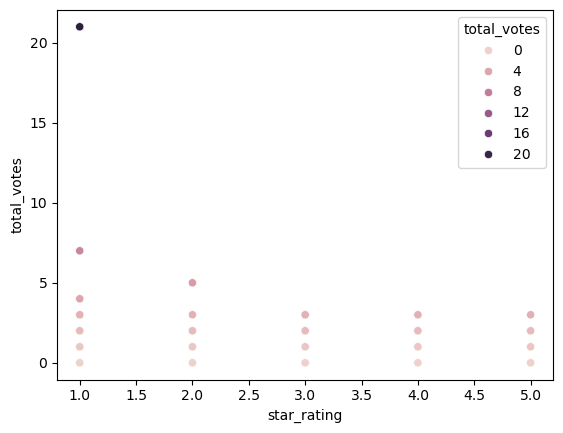

In [36]:
sns.scatterplot(data=df, x="star_rating",y='total_votes',hue="total_votes")

<AxesSubplot:xlabel='helpful_votes', ylabel='total_votes'>

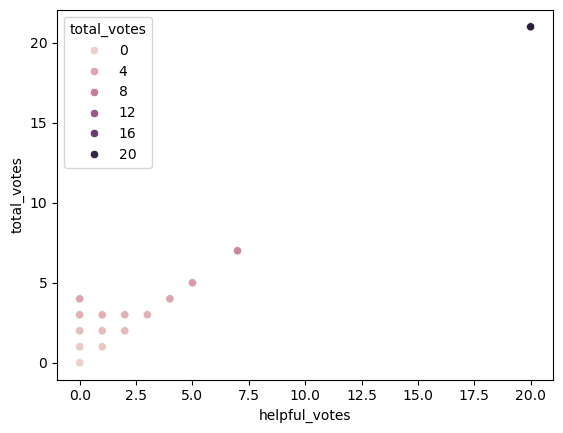

In [37]:
sns.scatterplot(data=df, x="helpful_votes",y='total_votes',hue="total_votes")

<AxesSubplot:>

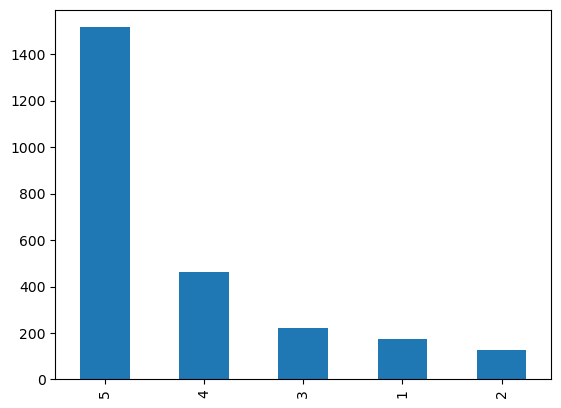

In [38]:
df["star_rating"].value_counts().plot.bar()

<AxesSubplot:>

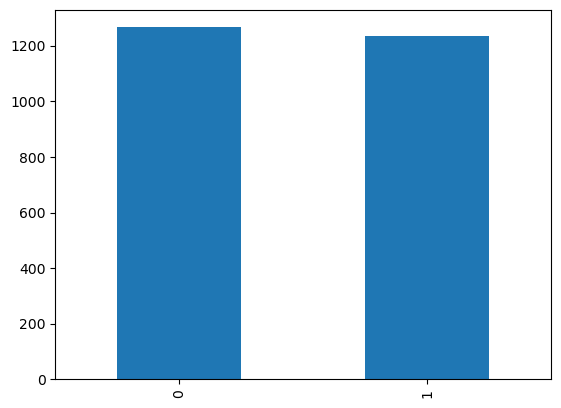

In [39]:
df["verified_purchase"].value_counts().plot.bar()

In [40]:
import re
df['review_body'] = df['review_body'].str.replace('<br /><br />', '', regex=False)
df['review_body'] = df['review_body'].str.replace(r'<br\s*/?>', ' ', regex=True, flags=re.IGNORECASE)


# Create X and y Feature variables

In [41]:
X,y = df.drop("sentiment", axis=1), df["sentiment"]

In [42]:
vectorizer = TfidfVectorizer(max_features=2000)

tfidf_matrix = vectorizer.fit_transform(df['review_body'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

X = pd.concat([X.drop("review_body", axis=1), tfidf_df], axis=1)

# Baseline Model Testing

In [43]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='stratified', constant=1) 

scores = evaluate_model(X, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.793 (0.018)


# Advanced Model Metrics

In [44]:
names = ['LR', 'SVC', 'GBC', 'XGB','GNB', 'KNN', 'DTC', 'RFC', 'GPC', 'LDA']

models = get_selected_models(names)
testing_selected_models(names, models, X, y)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean,STD
0,LR,1.000000,0.000000
1,SVC,1.000000,0.000000
2,GBC,1.000000,0.000000
3,XGB,1.000000,0.000000
5,KNN,1.000000,0.000000
6,DTC,1.000000,0.000000
8,GPC,1.000000,0.000000
7,RFC,0.997123,0.002919
4,GNB,0.834633,0.016872
9,LDA,0.777147,0.022296


# Models are overfitting

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score for XGB: 1.000
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Test accuracy for XGB: 1.000
---------------------------------------------------------------


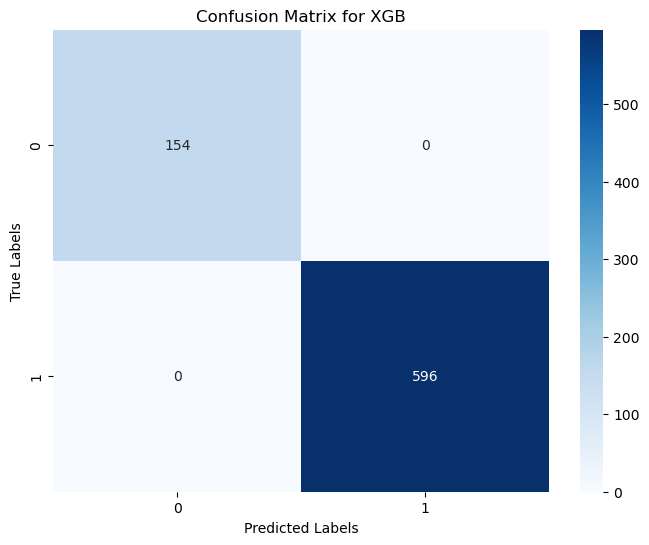

  Model  Best CV Score  Test Accuracy  \
0   XGB            1.0            1.0   

                                     Best Parameters  
0  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  


In [47]:
params = {'XGB': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}
names = ['XGB']
metric = make_scorer(f1_score)
models = get_selected_models(names)
grid_search_selected_models(params, names, models, X, y, metric)